In [1]:
import sklearn.preprocessing as preprocess
import numpy as np
import pandas as pd
from keras import optimizers
import keras.layers as kl
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import spacy
from keras.utils import to_categorical
from spacy.lang.en import English
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 1000)
from tqdm import tqdm_notebook
from keras.layers import BatchNormalization, Lambda, Concatenate, Dropout, Conv1D, MaxPooling1D, Input, TimeDistributed, Dense, LSTM, RepeatVector, GlobalAveragePooling1D
from keras.models import Model
import pickle
from datetime import datetime
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from AttentionModules import SelfAttention,CrossAttention
import sys,os
from sklearn.model_selection import KFold
import seaborn as sns
from sklearn import preprocessing
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [3]:
dnf700 = pd.read_json('evaluation_set/deepnofakes/dnf_700/initial.json')
dnf_eval = pd.read_json('evaluation_set/deepnofakes/Evaluation_Final_50_V2.json')
dnf_eval.columns = ['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type', 'urls'] 
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_array_id.p', 'rb') as fp:
    articles = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_700/dnf700_sent_vector_array_id.p', 'rb') as fp:
    article_vectors = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_array_id.p', 'rb') as fp:
    articles300 = pickle.load(fp)
with open('evaluation_set/deepnofakes/dnf_300/cleaned/cleaned_dnf300_sent_vector_array_id.p', 'rb') as fp:
    article_vectors300 = pickle.load(fp)
with open('evaluation_set/word_mapping/id_word_mapping.p', 'rb') as fp:
    id_word_mapping = pickle.load(fp)
dnf_eval.keys(), dnf700.keys(), len(articles.keys()), len(article_vectors.keys())

(Index(['authors', 'evidence', 'headline', 'id', 'reason', 'claims', 'type',
        'urls'],
       dtype='object'),
 Index(['authors', 'headline', 'id', 'type', 'urls'], dtype='object'),
 705,
 705)

In [4]:
num_splits = 5
kf = KFold(n_splits=num_splits)
train_batchsize = 32
val_batchsize = 32
test_batchsize = 50
train_steps_per_epoch = 4
val_steps_per_epoch = 1
epochs = 2000
max_sentences = 0
for idx in articles.keys():
    num = len(articles[idx])
    if num>=max_sentences:
        max_sentences = num
        
max_sentences

125

In [5]:
hdl = "George Soros: Trump Will Win Popular Vote by a Landslide but Clinton Victory a 'Done Deal'"
hdl = "Ted Cruz Said 'If Something Happens to Hillary' He'll 'Run as a Democrat Against Trump'"
# hdl = "If You Thought The Trump Child Rape Case In NY Couldn’t Get Much Worse — You Were Wrong"
# hdl = "California Set to Let Public Schools Teach Primarily in Spanish"
dnf700[dnf700.headline==hdl]

,authors,headline,id,type,urls


In [6]:
titles = sorted(dnf700.headline.unique())
len(titles)

698

In [7]:
test_titles = sorted(dnf_eval.headline.unique())
len(test_titles)
test_titles

['(VIDEO) Female College Students Protesting Because ‘Trump is a Rapist’',
 'Assange Confirms: WikiLeaks Didn’t Get Emails From Russian Govt',
 'BREAKING: Fraudulent Clinton Votes Discovered By The “Tens Of Thousands”',
 "Clinton Camp Demands 'Compliant Citizenry' for Master Plan",
 'Clinton Received Debate Questions Week Before Debate',
 "DOJ's Loretta Lynch Tried To Squash Comey's Letter To Congress",
 'Department of Homeland Security Chairman Officially Indicts Hillary Clinton of Treason',
 'Developing: Obama WH admits that Hillary gave ISIS $400 million on accident',
 'Erdoğan: US, the founder of ISIS',
 "FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com",
 'FBI Agent Suspected in Hillary Email Leaks Found Dead in Apparent Murder-Suicide',
 'FBI Director Comey’s ‘Leaked’ Memo Explains Why He’s Reopening the Clinton Email Case',
 'FBI director received millions from Clinton Foundation, his brother’s law firm does Clinton’s taxes',
 '

In [8]:
non_test_titles = np.array(list(set(titles)-set(test_titles)))
len(non_test_titles)

650

In [9]:
indices = []
for train_index, val_index in kf.split(non_test_titles):
    indices.append([train_index,val_index])

In [10]:

train_index, val_index = indices[np.random.randint(0,num_splits)]
print(train_index,val_index)
val_titles = non_test_titles[val_index]
train_titles = non_test_titles[train_index]
len(train_titles),len(val_titles),len(test_titles)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 260 261 262 263 264 265 266 267 268 269 270 271 272 273
 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291
 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309
 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327
 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345
 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363
 364 365 366 367 368 369 370 371 372 373 374 375 37

(520, 130, 50)

In [11]:
def load_spacy():
    sentencizer = English()
    sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))
    nlp = spacy.load("en_core_web_md")
    return sentencizer, nlp
sentencizer, nlp = load_spacy()


In [12]:

def datagen_dnf(batchsize,dataframe,mode):
    counter=0
    ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
    while True:
        if mode=='train':
            idx=np.random.choice(train_titles)
        elif mode=='val':
            idx=np.random.choice(val_titles)
        elif mode=='test':
            idx=np.random.choice(test_titles)
        idx = idx.strip()
        
            
#         cl = dataframe[dataframe.Article==idx]['Claim'].values
#         sentences=articles[ar_id]
#         print(len(sentences))
        if mode=='test':
            hd = dnf_eval[dnf_eval.headline==idx]['headline'].values[0].lower()
            ar_id = dnf_eval[dnf_eval.headline==idx]['id'].values[0]
            cl = dnf_eval[dnf_eval.headline==idx]['claims'].values[0]
            ar_claims.append(cl)
            sentences = articles300[ar_id]
            vectors = article_vectors300[ar_id]
        else:
            try:
                hd = dataframe[dataframe.headline==idx]['headline'].values[0].lower()
                ar_id = dataframe[dataframe.headline==idx]['id'].values[0]
                ar_claims.append('None')
                sentences=articles[ar_id]
                vectors = article_vectors[ar_id]
            except Exception as ex:
                print(ex)
                print(idx)
            
        hds.append(hd)
        ar_sentences.append(sentences)
#         print(len(sentences))
        sents = np.zeros((max_sentences,300))
        
        sents[:len(vectors)] = vectors
        ar_ids.append(ar_id)
        ar_sents.append(sents)
        hd_nlp = nlp(hd.lower())
        hd_nlp = hd_nlp[:50]
        head_classes = np.zeros(50, dtype='int')
        for i in range(len(hd_nlp)):
            head_classes[i] = hd_nlp[i].rank
        ar_head_vectors.append(hd_nlp.vector)
        ar_head_classes.append(to_categorical(num_classes=20000,y=head_classes))
        counter+=1
        if counter==batchsize:
            inputs = {
                'article_id': np.array(ar_ids)
                ,'headline': np.array(hds)
                ,'sentence_vectors' : np.array(ar_sents)
                ,'input_headline_vector': np.array(ar_head_vectors)
                ,'claims':np.array(ar_claims)
                ,'sentences':np.array(ar_sentences)
            }
            outputs = {
                'headline_token_classes': np.array(ar_head_classes)
                ,'output_headline_vector': np.array(ar_head_vectors)
            }
            yield inputs,outputs
            ar_ids,ar_sents,ar_head_vectors,ar_head_classes,hds,ar_claims, ar_sentences=[],[],[],[],[],[],[]
            counter=0
 

In [13]:
tdg = datagen_dnf(train_batchsize,dnf700,mode='train')
vdg = datagen_dnf(val_batchsize,dnf700,mode='val')
test_dg = datagen_dnf(test_batchsize,dnf700,mode='test')

In [14]:
x,y = next(test_dg)

In [15]:
# x['sentence_vectors'].shape, x['headline_vector'].shape, y['headline_token_classes'].shape

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 125, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 125, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 125, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 125, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

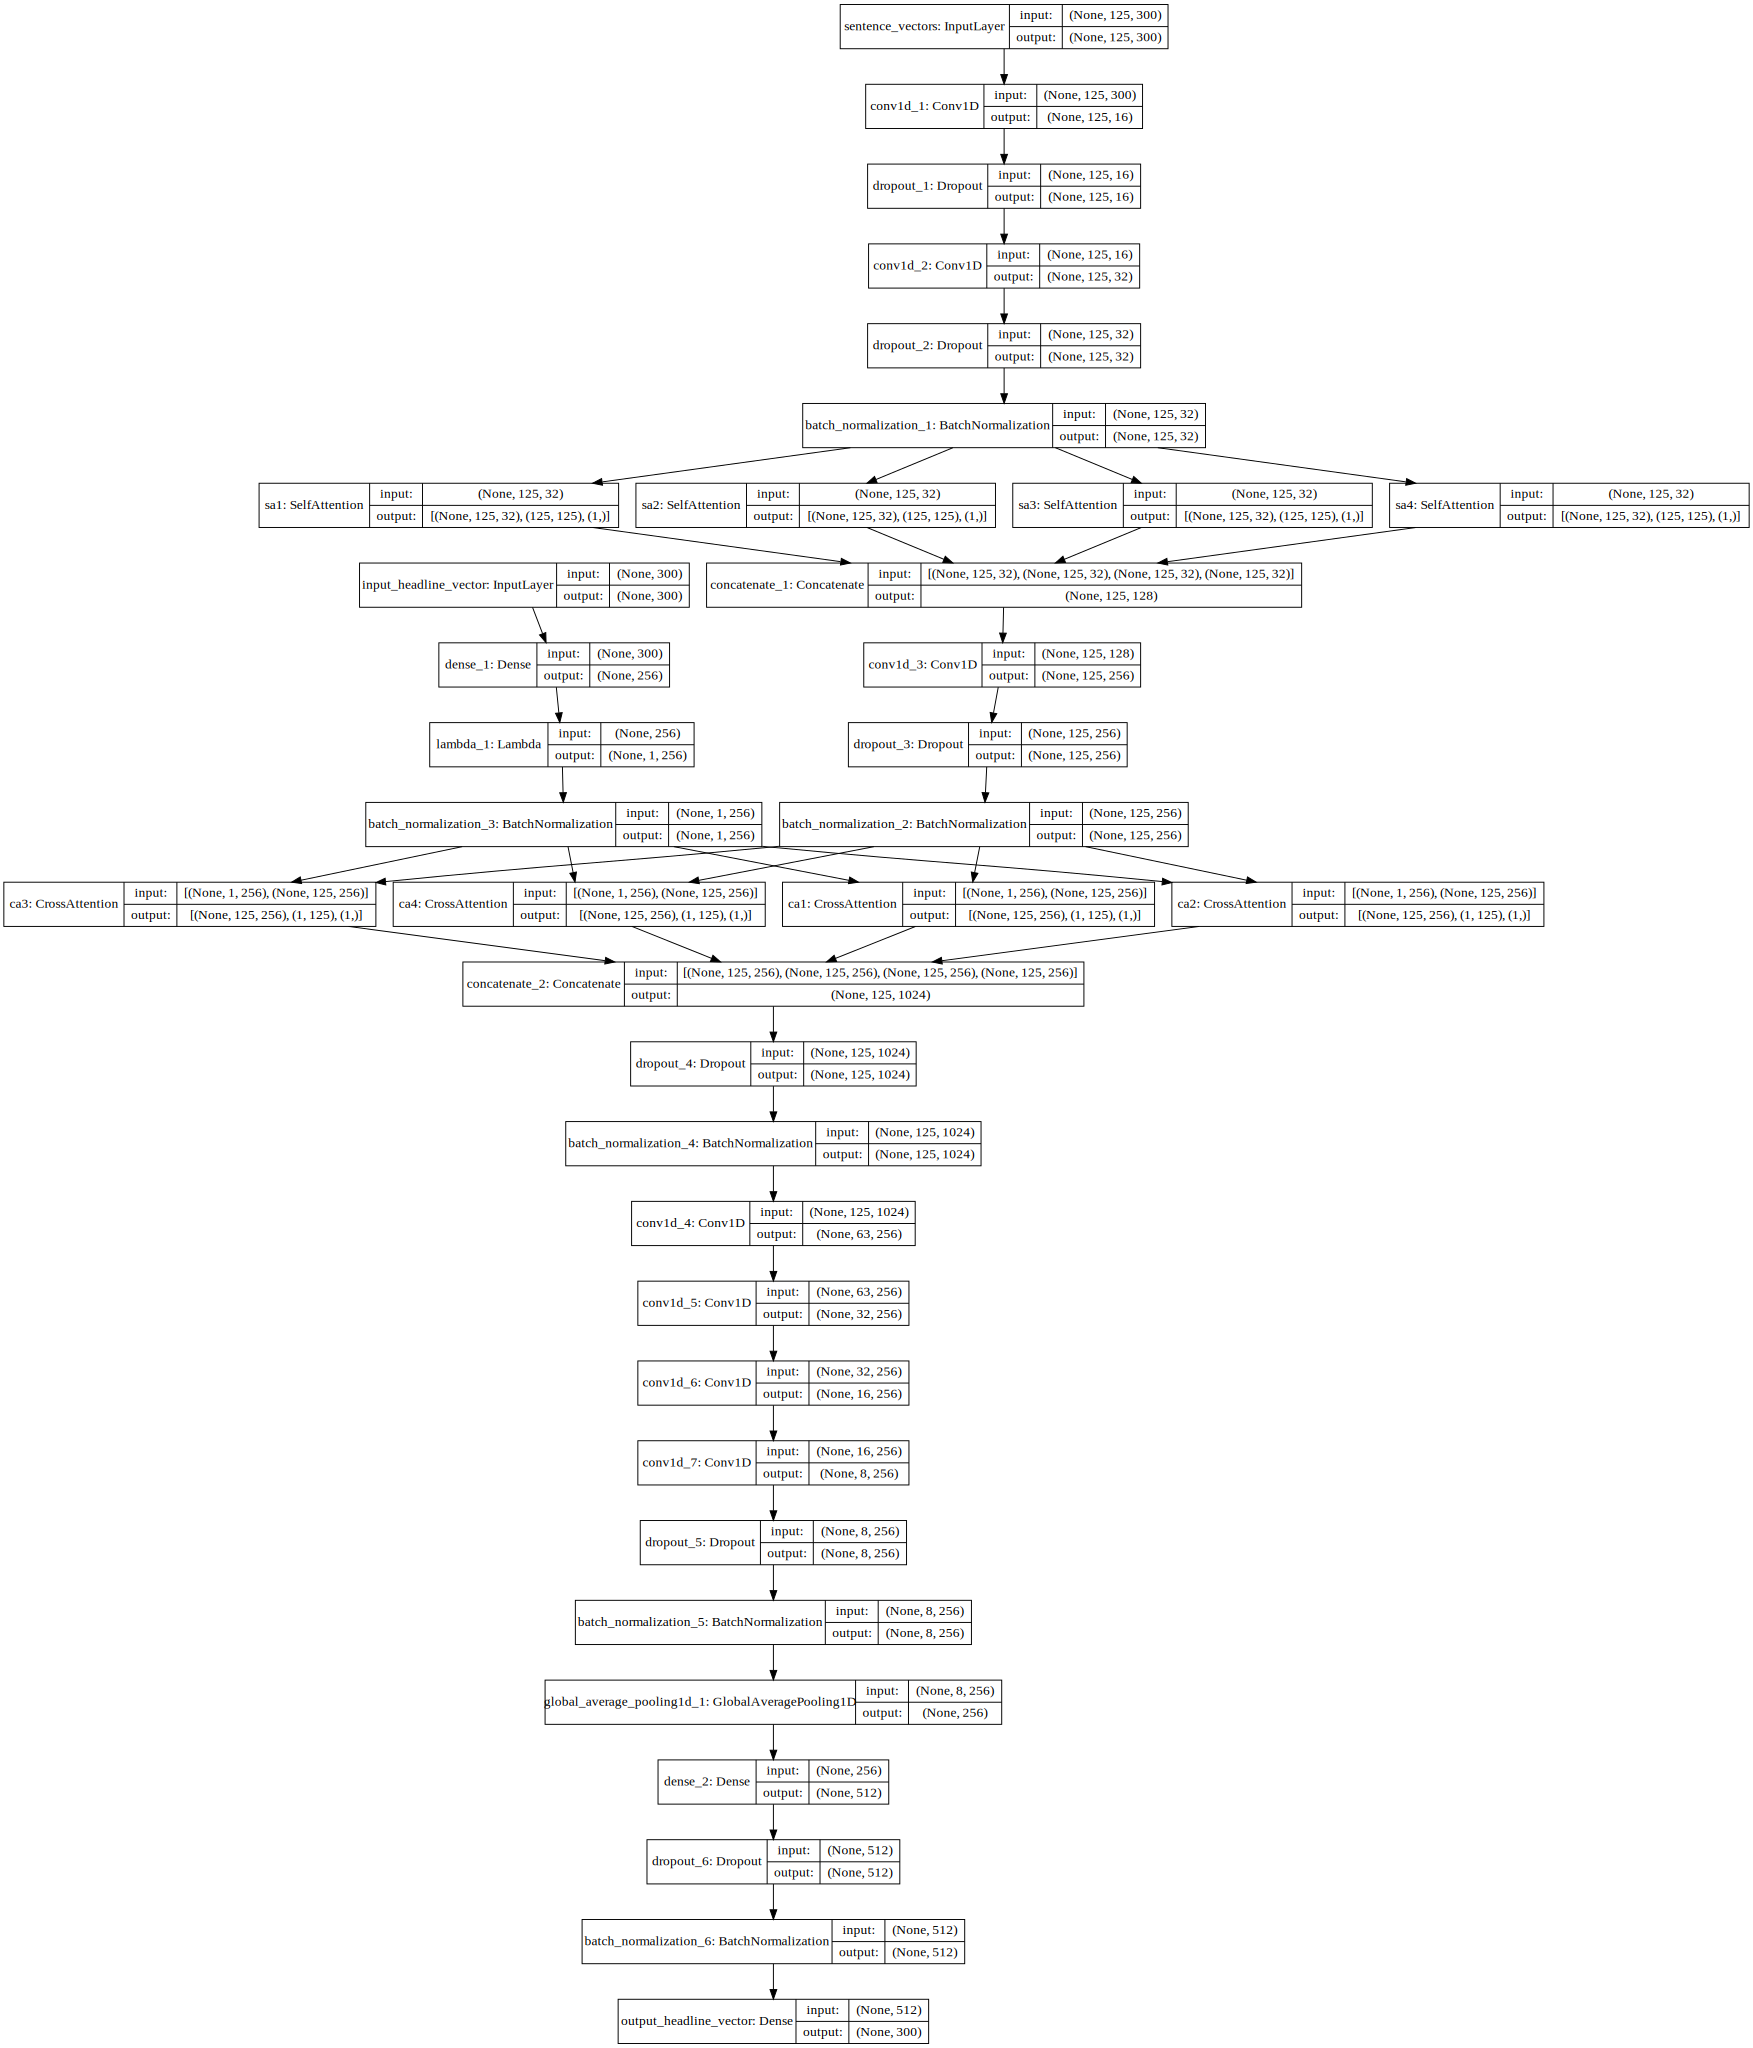

In [16]:
def build_model():
    inp_sentence_vectors = Input(shape=(max_sentences, 300), name='sentence_vectors')
    inp_headline_vector = Input(shape=(300,), name='input_headline_vector')
    conv1 = Conv1D(filters=16,kernel_size=3,strides=1,activation='relu', padding='same')(inp_sentence_vectors)
    conv1 = Dropout(0.5)(conv1)
    conv2 = Conv1D(filters=32,kernel_size=3,strides=1,activation='relu', padding='same')(conv1)
    conv2 = Dropout(0.5)(conv2)
    conv2 = BatchNormalization()(conv2)
    sent_sa_feat_1, sent_beta_1, sent_gamma_1 = SelfAttention(int(conv2.shape[-1]), name = 'sa1')(conv2)
    sent_sa_feat_2, sent_beta_2, sent_gamma_2 = SelfAttention(int(conv2.shape[-1]), name = 'sa2')(conv2)
    sent_sa_feat_3, sent_beta_3, sent_gamma_3 = SelfAttention(int(conv2.shape[-1]), name = 'sa3')(conv2)
    sent_sa_feat_4, sent_beta_4, sent_gamma_4 = SelfAttention(int(conv2.shape[-1]), name = 'sa4')(conv2)
    concat1 = Concatenate()([sent_sa_feat_1,sent_sa_feat_2,sent_sa_feat_3,sent_sa_feat_4])
    conv3 = Conv1D(filters=256,kernel_size=3, strides=1, activation='relu', padding='same')(concat1)
    conv3 = Dropout(0.5)(conv3)
    conv3 = BatchNormalization()(conv3)
    headline = Dense(256, activation='relu')(inp_headline_vector)
    headline = Lambda(lambda x:K.expand_dims(x, axis=1))(headline)
    headline = BatchNormalization()(headline)
    sent_hd_sa_feat_1, sent_hd_beta_1, sent_hd_gamma_1 = CrossAttention(int(conv3.shape[-1]), name = 'ca1')([headline,conv3])
    sent_hd_sa_feat_2, sent_hd_beta_2, sent_hd_gamma_2 = CrossAttention(int(conv3.shape[-1]), name = 'ca2')([headline,conv3])
    sent_hd_sa_feat_3, sent_hd_beta_3, sent_hd_gamma_3 = CrossAttention(int(conv3.shape[-1]), name = 'ca3')([headline,conv3])
    sent_hd_sa_feat_4, sent_hd_beta_4, sent_hd_gamma_4 = CrossAttention(int(conv3.shape[-1]), name = 'ca4')([headline,conv3])  
    concat3 = Concatenate()([sent_hd_sa_feat_1,sent_hd_sa_feat_2,sent_hd_sa_feat_3,sent_hd_sa_feat_4])
    concat3 = Dropout(0.5)(concat3)
    concat3 = BatchNormalization()(concat3)
    conv5 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(concat3)
    conv6 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv5)
    conv7 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv6)
    conv8 = Conv1D(filters=256,kernel_size=3, strides=2, activation='relu', padding='same')(conv7)
    conv8 = Dropout(0.5)(conv8)
    conv8 = BatchNormalization()(conv8)
    gap = GlobalAveragePooling1D()(conv8)
#     repeat = RepeatVector(50)(gap)
#     lstm = LSTM(256,return_sequences=True)(repeat)
    dense1 = Dense(512,activation='relu')(gap)
    dense1 = Dropout(0.5)(dense1)
    dense1 = BatchNormalization()(dense1)
    gen_hd_vector = Dense(300,activation='linear', name='output_headline_vector')(dense1)
    model = Model([inp_sentence_vectors,inp_headline_vector],gen_hd_vector)
    return model
model = build_model()
model.compile(optimizer=optimizers.Adam(lr=0.0001,beta_1=0.0,beta_2=0.99),loss='mse')
model.summary()
# print('model params:',model.count_params())
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [17]:
dt = datetime.now()
mc = ModelCheckpoint('weights/dnf700_sa_sent_hd_vector.hdf5',save_best_only=True,save_weights_only=True)
tb = TensorBoard(batch_size=32,log_dir='logs/dnf700_sa_sent_hd_vector/{0}'.format(dt.timestamp()),write_graph=True)

In [18]:
hist = model.fit_generator(tdg, callbacks=[mc,tb], initial_epoch=0
                           ,steps_per_epoch=train_steps_per_epoch
                           ,validation_data=vdg
                           ,validation_steps=val_steps_per_epoch
                           ,epochs=epochs)

Epoch 1/2000
4/4 [==============================] - 8s 2s/step - loss: 1.2458 - val_loss: 0.2802
Epoch 2/2000
4/4 [==============================] - 0s 51ms/step - loss: 1.2381 - val_loss: 0.2451
Epoch 3/2000
4/4 [==============================] - 0s 56ms/step - loss: 1.2197 - val_loss: 0.2304
Epoch 4/2000
4/4 [==============================] - 1s 242ms/step - loss: 1.2212 - val_loss: 0.2102
Epoch 5/2000
4/4 [==============================] - 2s 482ms/step - loss: 1.2119 - val_loss: 0.1897
Epoch 6/2000
4/4 [==============================] - 2s 422ms/step - loss: 1.2063 - val_loss: 0.1879
Epoch 7/2000
4/4 [==============================] - 2s 394ms/step - loss: 1.2090 - val_loss: 0.1809
Epoch 8/2000
4/4 [==============================] - 2s 408ms/step - loss: 1.1747 - val_loss: 0.1796
Epoch 9/2000
4/4 [==============================] - 2s 427ms/step - loss: 1.1615 - val_loss: 0.1665
Epoch 10/2000
4/4 [==============================] - 2s 410ms/step - loss: 1.1626 - val_loss: 0.1608
Epoc

4/4 [==============================] - 2s 416ms/step - loss: 0.7073 - val_loss: 0.0529
Epoch 83/2000
4/4 [==============================] - 2s 439ms/step - loss: 0.7265 - val_loss: 0.0494
Epoch 84/2000
4/4 [==============================] - 2s 434ms/step - loss: 0.7075 - val_loss: 0.0507
Epoch 85/2000
4/4 [==============================] - 2s 434ms/step - loss: 0.7042 - val_loss: 0.0533
Epoch 86/2000
4/4 [==============================] - 2s 431ms/step - loss: 0.7094 - val_loss: 0.0488
Epoch 87/2000
4/4 [==============================] - 2s 419ms/step - loss: 0.7054 - val_loss: 0.0507
Epoch 88/2000
4/4 [==============================] - 2s 424ms/step - loss: 0.6835 - val_loss: 0.0542
Epoch 89/2000
4/4 [==============================] - 2s 436ms/step - loss: 0.6922 - val_loss: 0.0445
Epoch 90/2000
4/4 [==============================] - 2s 427ms/step - loss: 0.6955 - val_loss: 0.0501
Epoch 91/2000
4/4 [==============================] - 2s 428ms/step - loss: 0.6821 - val_loss: 0.0515
Epoc

4/4 [==============================] - 2s 511ms/step - loss: 0.4956 - val_loss: 0.0245
Epoch 163/2000
4/4 [==============================] - 2s 474ms/step - loss: 0.4864 - val_loss: 0.0211
Epoch 164/2000
4/4 [==============================] - 2s 448ms/step - loss: 0.4592 - val_loss: 0.0235
Epoch 165/2000
4/4 [==============================] - 2s 432ms/step - loss: 0.4911 - val_loss: 0.0256
Epoch 166/2000
4/4 [==============================] - 2s 556ms/step - loss: 0.4785 - val_loss: 0.0235
Epoch 167/2000
4/4 [==============================] - 2s 516ms/step - loss: 0.4662 - val_loss: 0.0246
Epoch 168/2000
4/4 [==============================] - 2s 439ms/step - loss: 0.4682 - val_loss: 0.0222
Epoch 169/2000
4/4 [==============================] - 2s 455ms/step - loss: 0.4748 - val_loss: 0.0222
Epoch 170/2000
4/4 [==============================] - 2s 463ms/step - loss: 0.4614 - val_loss: 0.0262
Epoch 171/2000
4/4 [==============================] - 2s 441ms/step - loss: 0.4654 - val_loss: 0.

4/4 [==============================] - 3s 778ms/step - loss: 0.2234 - val_loss: 0.0136
Epoch 243/2000
4/4 [==============================] - 3s 758ms/step - loss: 0.2413 - val_loss: 0.0144
Epoch 244/2000
4/4 [==============================] - 3s 730ms/step - loss: 0.2135 - val_loss: 0.0155
Epoch 245/2000
4/4 [==============================] - 3s 649ms/step - loss: 0.2057 - val_loss: 0.0201
Epoch 246/2000
4/4 [==============================] - 3s 724ms/step - loss: 0.2139 - val_loss: 0.0140
Epoch 247/2000
4/4 [==============================] - 2s 604ms/step - loss: 0.2100 - val_loss: 0.0174
Epoch 248/2000
4/4 [==============================] - 3s 740ms/step - loss: 0.2001 - val_loss: 0.0129
Epoch 249/2000
4/4 [==============================] - 3s 762ms/step - loss: 0.1808 - val_loss: 0.0134
Epoch 250/2000
4/4 [==============================] - 3s 717ms/step - loss: 0.1890 - val_loss: 0.0132
Epoch 251/2000
4/4 [==============================] - 3s 779ms/step - loss: 0.1914 - val_loss: 0.

4/4 [==============================] - 3s 760ms/step - loss: 0.0138 - val_loss: 0.0117
Epoch 323/2000
4/4 [==============================] - 3s 684ms/step - loss: 0.0134 - val_loss: 0.0114
Epoch 324/2000
4/4 [==============================] - 3s 712ms/step - loss: 0.0178 - val_loss: 0.0119
Epoch 325/2000
4/4 [==============================] - 3s 760ms/step - loss: 0.0132 - val_loss: 0.0118
Epoch 326/2000
4/4 [==============================] - 3s 660ms/step - loss: 0.0136 - val_loss: 0.0138
Epoch 327/2000
4/4 [==============================] - 3s 641ms/step - loss: 0.0136 - val_loss: 0.0106
Epoch 328/2000
4/4 [==============================] - 2s 602ms/step - loss: 0.0165 - val_loss: 0.0099
Epoch 329/2000
4/4 [==============================] - 3s 708ms/step - loss: 0.0126 - val_loss: 0.0108
Epoch 330/2000
4/4 [==============================] - 3s 687ms/step - loss: 0.0141 - val_loss: 0.0098
Epoch 331/2000
4/4 [==============================] - 3s 734ms/step - loss: 0.0140 - val_loss: 0.

4/4 [==============================] - 3s 749ms/step - loss: 0.0106 - val_loss: 0.0112
Epoch 403/2000
4/4 [==============================] - 3s 678ms/step - loss: 0.0112 - val_loss: 0.0118
Epoch 404/2000
4/4 [==============================] - 3s 710ms/step - loss: 0.0111 - val_loss: 0.0101
Epoch 405/2000
4/4 [==============================] - 3s 653ms/step - loss: 0.0124 - val_loss: 0.0097
Epoch 406/2000
4/4 [==============================] - 2s 614ms/step - loss: 0.0125 - val_loss: 0.0109
Epoch 407/2000
4/4 [==============================] - 3s 629ms/step - loss: 0.0108 - val_loss: 0.0128
Epoch 408/2000
4/4 [==============================] - 3s 636ms/step - loss: 0.0128 - val_loss: 0.0114
Epoch 409/2000
4/4 [==============================] - 3s 758ms/step - loss: 0.0110 - val_loss: 0.0117
Epoch 410/2000
4/4 [==============================] - 3s 719ms/step - loss: 0.0105 - val_loss: 0.0106
Epoch 411/2000
4/4 [==============================] - 3s 630ms/step - loss: 0.0109 - val_loss: 0.

4/4 [==============================] - 3s 700ms/step - loss: 0.0117 - val_loss: 0.0111
Epoch 483/2000
4/4 [==============================] - 3s 692ms/step - loss: 0.0104 - val_loss: 0.0124
Epoch 484/2000
4/4 [==============================] - 3s 706ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 485/2000
4/4 [==============================] - 3s 686ms/step - loss: 0.0117 - val_loss: 0.0114
Epoch 486/2000
4/4 [==============================] - 3s 706ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 487/2000
4/4 [==============================] - 3s 774ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 488/2000
4/4 [==============================] - 3s 748ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 489/2000
4/4 [==============================] - 3s 748ms/step - loss: 0.0112 - val_loss: 0.0104
Epoch 490/2000
4/4 [==============================] - 3s 711ms/step - loss: 0.0108 - val_loss: 0.0102
Epoch 491/2000
4/4 [==============================] - 3s 692ms/step - loss: 0.0105 - val_loss: 0.

4/4 [==============================] - 3s 723ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 563/2000
4/4 [==============================] - 3s 714ms/step - loss: 0.0104 - val_loss: 0.0118
Epoch 564/2000
4/4 [==============================] - 3s 805ms/step - loss: 0.0116 - val_loss: 0.0104
Epoch 565/2000
4/4 [==============================] - 3s 687ms/step - loss: 0.0119 - val_loss: 0.0114
Epoch 566/2000
4/4 [==============================] - 3s 776ms/step - loss: 0.0109 - val_loss: 0.0099
Epoch 567/2000
4/4 [==============================] - 3s 811ms/step - loss: 0.0107 - val_loss: 0.0101
Epoch 568/2000
4/4 [==============================] - 3s 796ms/step - loss: 0.0107 - val_loss: 0.0134
Epoch 569/2000
4/4 [==============================] - 3s 728ms/step - loss: 0.0111 - val_loss: 0.0102
Epoch 570/2000
4/4 [==============================] - 3s 790ms/step - loss: 0.0103 - val_loss: 0.0121
Epoch 571/2000
4/4 [==============================] - 2s 586ms/step - loss: 0.0102 - val_loss: 0.

4/4 [==============================] - 3s 701ms/step - loss: 0.0112 - val_loss: 0.0121
Epoch 643/2000
4/4 [==============================] - 3s 654ms/step - loss: 0.0104 - val_loss: 0.0092
Epoch 644/2000
4/4 [==============================] - 3s 660ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 645/2000
4/4 [==============================] - 3s 795ms/step - loss: 0.0109 - val_loss: 0.0112
Epoch 646/2000
4/4 [==============================] - 2s 624ms/step - loss: 0.0110 - val_loss: 0.0115
Epoch 647/2000
4/4 [==============================] - 3s 657ms/step - loss: 0.0111 - val_loss: 0.0105
Epoch 648/2000
4/4 [==============================] - 2s 557ms/step - loss: 0.0101 - val_loss: 0.0108
Epoch 649/2000
4/4 [==============================] - 2s 593ms/step - loss: 0.0107 - val_loss: 0.0221
Epoch 650/2000
4/4 [==============================] - 3s 677ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 651/2000
4/4 [==============================] - 3s 729ms/step - loss: 0.0109 - val_loss: 0.

4/4 [==============================] - 3s 704ms/step - loss: 0.0115 - val_loss: 0.0095
Epoch 723/2000
4/4 [==============================] - 3s 753ms/step - loss: 0.0105 - val_loss: 0.0124
Epoch 724/2000
4/4 [==============================] - 3s 711ms/step - loss: 0.0120 - val_loss: 0.0118
Epoch 725/2000
4/4 [==============================] - 3s 637ms/step - loss: 0.0105 - val_loss: 0.0111
Epoch 726/2000
4/4 [==============================] - 2s 578ms/step - loss: 0.0107 - val_loss: 0.0111
Epoch 727/2000
4/4 [==============================] - 3s 625ms/step - loss: 0.0101 - val_loss: 0.0119
Epoch 728/2000
4/4 [==============================] - 3s 703ms/step - loss: 0.0127 - val_loss: 0.0114
Epoch 729/2000
4/4 [==============================] - 3s 803ms/step - loss: 0.0105 - val_loss: 0.0109
Epoch 730/2000
4/4 [==============================] - 3s 712ms/step - loss: 0.0107 - val_loss: 0.0123
Epoch 731/2000
4/4 [==============================] - 3s 739ms/step - loss: 0.0088 - val_loss: 0.

4/4 [==============================] - 3s 759ms/step - loss: 0.0111 - val_loss: 0.0097
Epoch 803/2000
4/4 [==============================] - 3s 707ms/step - loss: 0.0102 - val_loss: 0.0107
Epoch 804/2000
4/4 [==============================] - 3s 862ms/step - loss: 0.0109 - val_loss: 0.0104
Epoch 805/2000
4/4 [==============================] - 3s 659ms/step - loss: 0.0112 - val_loss: 0.0093
Epoch 806/2000
4/4 [==============================] - 3s 667ms/step - loss: 0.0100 - val_loss: 0.0132
Epoch 807/2000
4/4 [==============================] - 3s 719ms/step - loss: 0.0097 - val_loss: 0.0118
Epoch 808/2000
4/4 [==============================] - 3s 716ms/step - loss: 0.0119 - val_loss: 0.0096
Epoch 809/2000
4/4 [==============================] - 3s 779ms/step - loss: 0.0106 - val_loss: 0.0131
Epoch 810/2000
4/4 [==============================] - 3s 831ms/step - loss: 0.0113 - val_loss: 0.0121
Epoch 811/2000
4/4 [==============================] - 2s 612ms/step - loss: 0.0118 - val_loss: 0.

4/4 [==============================] - 2s 576ms/step - loss: 0.0108 - val_loss: 1.2415
Epoch 883/2000
4/4 [==============================] - 2s 605ms/step - loss: 0.0113 - val_loss: 0.1179
Epoch 884/2000
4/4 [==============================] - 2s 624ms/step - loss: 0.0132 - val_loss: 0.0587
Epoch 885/2000
4/4 [==============================] - 3s 681ms/step - loss: 0.0123 - val_loss: 0.0940
Epoch 886/2000
4/4 [==============================] - 3s 649ms/step - loss: 0.0114 - val_loss: 0.0320
Epoch 887/2000
4/4 [==============================] - 2s 605ms/step - loss: 0.0103 - val_loss: 0.0227
Epoch 888/2000
4/4 [==============================] - 3s 625ms/step - loss: 0.0120 - val_loss: 0.0105
Epoch 889/2000
4/4 [==============================] - 3s 688ms/step - loss: 0.0112 - val_loss: 0.0146
Epoch 890/2000
4/4 [==============================] - 3s 684ms/step - loss: 0.0122 - val_loss: 0.0123
Epoch 891/2000
4/4 [==============================] - 3s 689ms/step - loss: 0.0106 - val_loss: 0.

4/4 [==============================] - 2s 609ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 963/2000
4/4 [==============================] - 2s 585ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 964/2000
4/4 [==============================] - 3s 715ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 965/2000
4/4 [==============================] - 3s 733ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 966/2000
4/4 [==============================] - 3s 685ms/step - loss: 0.0109 - val_loss: 0.0117
Epoch 967/2000
4/4 [==============================] - 3s 692ms/step - loss: 0.0102 - val_loss: 0.0117
Epoch 968/2000
4/4 [==============================] - 3s 675ms/step - loss: 0.0110 - val_loss: 0.0102
Epoch 969/2000
4/4 [==============================] - 4s 895ms/step - loss: 0.0109 - val_loss: 0.0092
Epoch 970/2000
4/4 [==============================] - 3s 781ms/step - loss: 0.0110 - val_loss: 0.0122
Epoch 971/2000
4/4 [==============================] - 3s 731ms/step - loss: 0.0101 - val_loss: 0.

4/4 [==============================] - 3s 667ms/step - loss: 0.0106 - val_loss: 0.0133
Epoch 1043/2000
4/4 [==============================] - 3s 723ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 1044/2000
4/4 [==============================] - 3s 717ms/step - loss: 0.0103 - val_loss: 0.0086
Epoch 1045/2000
4/4 [==============================] - 3s 682ms/step - loss: 0.0143 - val_loss: 3.2309
Epoch 1046/2000
4/4 [==============================] - 2s 600ms/step - loss: 0.0124 - val_loss: 0.1843
Epoch 1047/2000
4/4 [==============================] - 3s 653ms/step - loss: 0.0101 - val_loss: 0.4936
Epoch 1048/2000
4/4 [==============================] - 3s 669ms/step - loss: 0.0115 - val_loss: 0.0830
Epoch 1049/2000
4/4 [==============================] - 3s 791ms/step - loss: 0.0106 - val_loss: 0.0314
Epoch 1050/2000
4/4 [==============================] - 3s 640ms/step - loss: 0.0112 - val_loss: 181.5221
Epoch 1051/2000
4/4 [==============================] - 3s 647ms/step - loss: 0.0112 - v

4/4 [==============================] - 3s 662ms/step - loss: 0.0108 - val_loss: 0.0117
Epoch 1122/2000
4/4 [==============================] - 3s 717ms/step - loss: 0.0104 - val_loss: 0.0172
Epoch 1123/2000
4/4 [==============================] - 3s 758ms/step - loss: 0.0123 - val_loss: 0.0128
Epoch 1124/2000
4/4 [==============================] - 3s 641ms/step - loss: 0.0114 - val_loss: 0.0120
Epoch 1125/2000
4/4 [==============================] - 3s 674ms/step - loss: 0.0111 - val_loss: 0.0116
Epoch 1126/2000
4/4 [==============================] - 3s 741ms/step - loss: 0.0106 - val_loss: 0.0107
Epoch 1127/2000
4/4 [==============================] - 3s 654ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 1128/2000
4/4 [==============================] - 3s 669ms/step - loss: 0.0110 - val_loss: 0.0115
Epoch 1129/2000
4/4 [==============================] - 3s 688ms/step - loss: 0.0107 - val_loss: 0.0118
Epoch 1130/2000
4/4 [==============================] - 3s 701ms/step - loss: 0.0105 - val

4/4 [==============================] - 3s 701ms/step - loss: 0.0111 - val_loss: 0.0092
Epoch 1201/2000
4/4 [==============================] - 3s 631ms/step - loss: 0.0104 - val_loss: 0.0112
Epoch 1202/2000
4/4 [==============================] - 3s 724ms/step - loss: 0.0117 - val_loss: 0.0131
Epoch 1203/2000
4/4 [==============================] - 3s 722ms/step - loss: 0.0109 - val_loss: 0.0106
Epoch 1204/2000
4/4 [==============================] - 3s 684ms/step - loss: 0.0105 - val_loss: 0.0092
Epoch 1205/2000
4/4 [==============================] - 3s 646ms/step - loss: 0.0118 - val_loss: 0.0106
Epoch 1206/2000
4/4 [==============================] - 3s 727ms/step - loss: 0.0114 - val_loss: 0.0136
Epoch 1207/2000
4/4 [==============================] - 3s 713ms/step - loss: 0.0121 - val_loss: 0.0117
Epoch 1208/2000
4/4 [==============================] - 3s 638ms/step - loss: 0.0111 - val_loss: 0.0094
Epoch 1209/2000
4/4 [==============================] - 3s 653ms/step - loss: 0.0110 - val

4/4 [==============================] - 3s 665ms/step - loss: 0.0102 - val_loss: 0.0107
Epoch 1280/2000
4/4 [==============================] - 3s 811ms/step - loss: 0.0114 - val_loss: 1024.5396
Epoch 1281/2000
4/4 [==============================] - 3s 708ms/step - loss: 0.0105 - val_loss: 0.0355
Epoch 1282/2000
4/4 [==============================] - 3s 727ms/step - loss: 0.0108 - val_loss: 0.0129
Epoch 1283/2000
4/4 [==============================] - 3s 734ms/step - loss: 0.0106 - val_loss: 0.0116
Epoch 1284/2000
4/4 [==============================] - 3s 703ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 1285/2000
4/4 [==============================] - 3s 747ms/step - loss: 0.0110 - val_loss: 0.0091
Epoch 1286/2000
4/4 [==============================] - 3s 684ms/step - loss: 0.0109 - val_loss: 0.0127
Epoch 1287/2000
4/4 [==============================] - 2s 613ms/step - loss: 0.0116 - val_loss: 0.0099
Epoch 1288/2000
4/4 [==============================] - 3s 698ms/step - loss: 0.0111 - 

4/4 [==============================] - 3s 660ms/step - loss: 0.0123 - val_loss: 0.0088
Epoch 1359/2000
4/4 [==============================] - 3s 781ms/step - loss: 0.0109 - val_loss: 0.0095
Epoch 1360/2000
4/4 [==============================] - 3s 679ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 1361/2000
4/4 [==============================] - 3s 749ms/step - loss: 0.0102 - val_loss: 0.0101
Epoch 1362/2000
4/4 [==============================] - 3s 864ms/step - loss: 0.0105 - val_loss: 0.0124
Epoch 1363/2000
4/4 [==============================] - 2s 544ms/step - loss: 0.0108 - val_loss: 0.0117
Epoch 1364/2000
4/4 [==============================] - 3s 640ms/step - loss: 0.0121 - val_loss: 0.0094
Epoch 1365/2000
4/4 [==============================] - 3s 631ms/step - loss: 0.0112 - val_loss: 0.0116
Epoch 1366/2000
4/4 [==============================] - 3s 634ms/step - loss: 0.0109 - val_loss: 0.0121
Epoch 1367/2000
4/4 [==============================] - 3s 755ms/step - loss: 0.0122 - val

4/4 [==============================] - 3s 740ms/step - loss: 0.0105 - val_loss: 0.0112
Epoch 1438/2000
4/4 [==============================] - 3s 645ms/step - loss: 0.0116 - val_loss: 0.0096
Epoch 1439/2000
4/4 [==============================] - 3s 651ms/step - loss: 0.0101 - val_loss: 0.0118
Epoch 1440/2000
4/4 [==============================] - 3s 734ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 1441/2000
4/4 [==============================] - 3s 810ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 1442/2000
4/4 [==============================] - 3s 682ms/step - loss: 0.0110 - val_loss: 0.0119
Epoch 1443/2000
4/4 [==============================] - 3s 798ms/step - loss: 0.0113 - val_loss: 0.0117
Epoch 1444/2000
4/4 [==============================] - 3s 755ms/step - loss: 0.0105 - val_loss: 0.0117
Epoch 1445/2000
4/4 [==============================] - 3s 699ms/step - loss: 0.0111 - val_loss: 0.0100
Epoch 1446/2000
4/4 [==============================] - 3s 688ms/step - loss: 0.0114 - val

4/4 [==============================] - 3s 837ms/step - loss: 0.0105 - val_loss: 0.0105
Epoch 1517/2000
4/4 [==============================] - 3s 657ms/step - loss: 0.0109 - val_loss: 0.0120
Epoch 1518/2000
4/4 [==============================] - 3s 682ms/step - loss: 0.0104 - val_loss: 0.0106
Epoch 1519/2000
4/4 [==============================] - 3s 709ms/step - loss: 0.0107 - val_loss: 0.0097
Epoch 1520/2000
4/4 [==============================] - 3s 697ms/step - loss: 0.0119 - val_loss: 0.0101
Epoch 1521/2000
4/4 [==============================] - 2s 579ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 1522/2000
4/4 [==============================] - 3s 714ms/step - loss: 0.0108 - val_loss: 0.0115
Epoch 1523/2000
4/4 [==============================] - 3s 772ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 1524/2000
4/4 [==============================] - 3s 699ms/step - loss: 0.0132 - val_loss: 0.0104
Epoch 1525/2000
4/4 [==============================] - 3s 735ms/step - loss: 0.0112 - val

4/4 [==============================] - 3s 791ms/step - loss: 0.0107 - val_loss: 0.0091
Epoch 1596/2000
4/4 [==============================] - 3s 707ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 1597/2000
4/4 [==============================] - 3s 673ms/step - loss: 0.0105 - val_loss: 0.0107
Epoch 1598/2000
4/4 [==============================] - 3s 643ms/step - loss: 0.0103 - val_loss: 0.0136
Epoch 1599/2000
4/4 [==============================] - 3s 755ms/step - loss: 0.0105 - val_loss: 0.0084
Epoch 1600/2000
4/4 [==============================] - 3s 663ms/step - loss: 0.0113 - val_loss: 0.0104
Epoch 1601/2000
4/4 [==============================] - 3s 636ms/step - loss: 0.0104 - val_loss: 0.0107
Epoch 1602/2000
4/4 [==============================] - 3s 729ms/step - loss: 0.0106 - val_loss: 0.0124
Epoch 1603/2000
4/4 [==============================] - 2s 616ms/step - loss: 0.0114 - val_loss: 0.0110
Epoch 1604/2000
4/4 [==============================] - 2s 584ms/step - loss: 0.0115 - val

4/4 [==============================] - 3s 674ms/step - loss: 0.0111 - val_loss: 0.0120
Epoch 1675/2000
4/4 [==============================] - 3s 707ms/step - loss: 0.0100 - val_loss: 0.0120
Epoch 1676/2000
4/4 [==============================] - 3s 676ms/step - loss: 0.0109 - val_loss: 0.0118
Epoch 1677/2000
4/4 [==============================] - 3s 737ms/step - loss: 0.0111 - val_loss: 0.0134
Epoch 1678/2000
4/4 [==============================] - 3s 760ms/step - loss: 0.0113 - val_loss: 0.0123
Epoch 1679/2000
4/4 [==============================] - 3s 717ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 1680/2000
4/4 [==============================] - 3s 733ms/step - loss: 0.0103 - val_loss: 0.0123
Epoch 1681/2000
4/4 [==============================] - 3s 741ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 1682/2000
4/4 [==============================] - 3s 703ms/step - loss: 0.0119 - val_loss: 0.0100
Epoch 1683/2000
4/4 [==============================] - 3s 814ms/step - loss: 0.0114 - val

4/4 [==============================] - 2s 610ms/step - loss: 0.0124 - val_loss: 0.0124
Epoch 1754/2000
4/4 [==============================] - 2s 590ms/step - loss: 0.0115 - val_loss: 0.0100
Epoch 1755/2000
4/4 [==============================] - 3s 670ms/step - loss: 0.0105 - val_loss: 0.0133
Epoch 1756/2000
4/4 [==============================] - 3s 702ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 1757/2000
4/4 [==============================] - 3s 649ms/step - loss: 0.0114 - val_loss: 0.0095
Epoch 1758/2000
4/4 [==============================] - 2s 615ms/step - loss: 0.0106 - val_loss: 0.0132
Epoch 1759/2000
4/4 [==============================] - 3s 703ms/step - loss: 0.0116 - val_loss: 0.0108
Epoch 1760/2000
4/4 [==============================] - 3s 798ms/step - loss: 0.0104 - val_loss: 0.0120
Epoch 1761/2000
4/4 [==============================] - 3s 689ms/step - loss: 0.0111 - val_loss: 0.0117
Epoch 1762/2000
4/4 [==============================] - 3s 706ms/step - loss: 0.0117 - val

4/4 [==============================] - 3s 748ms/step - loss: 0.0103 - val_loss: 0.0115
Epoch 1833/2000
4/4 [==============================] - 3s 766ms/step - loss: 0.0121 - val_loss: 0.0135
Epoch 1834/2000
4/4 [==============================] - 3s 717ms/step - loss: 0.0102 - val_loss: 0.0109
Epoch 1835/2000
4/4 [==============================] - 3s 661ms/step - loss: 0.0101 - val_loss: 0.0116
Epoch 1836/2000
4/4 [==============================] - 3s 700ms/step - loss: 0.0108 - val_loss: 0.0101
Epoch 1837/2000
4/4 [==============================] - 3s 683ms/step - loss: 0.0099 - val_loss: 0.0118
Epoch 1838/2000
4/4 [==============================] - 3s 715ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 1839/2000
4/4 [==============================] - 3s 637ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 1840/2000
4/4 [==============================] - 3s 709ms/step - loss: 0.0105 - val_loss: 0.0132
Epoch 1841/2000
4/4 [==============================] - 2s 600ms/step - loss: 0.0105 - val

4/4 [==============================] - 3s 713ms/step - loss: 0.0115 - val_loss: 0.0111
Epoch 1912/2000
4/4 [==============================] - 3s 689ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 1913/2000
4/4 [==============================] - 3s 751ms/step - loss: 0.0109 - val_loss: 0.0087
Epoch 1914/2000
4/4 [==============================] - 3s 791ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 1915/2000
4/4 [==============================] - 3s 763ms/step - loss: 0.0112 - val_loss: 0.0088
Epoch 1916/2000
4/4 [==============================] - 3s 703ms/step - loss: 0.0114 - val_loss: 0.0091
Epoch 1917/2000
4/4 [==============================] - 3s 730ms/step - loss: 0.0108 - val_loss: 0.0101
Epoch 1918/2000
4/4 [==============================] - 3s 708ms/step - loss: 0.0105 - val_loss: 0.0119
Epoch 1919/2000
4/4 [==============================] - 3s 708ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 1920/2000
4/4 [==============================] - 3s 704ms/step - loss: 0.0106 - val

4/4 [==============================] - 3s 643ms/step - loss: 0.0106 - val_loss: 0.0111
Epoch 1991/2000
4/4 [==============================] - 3s 689ms/step - loss: 0.0105 - val_loss: 0.0115
Epoch 1992/2000
4/4 [==============================] - 3s 854ms/step - loss: 0.0108 - val_loss: 0.0121
Epoch 1993/2000
4/4 [==============================] - 3s 762ms/step - loss: 0.0104 - val_loss: 0.0119
Epoch 1994/2000
4/4 [==============================] - 3s 794ms/step - loss: 0.0108 - val_loss: 0.0115
Epoch 1995/2000
4/4 [==============================] - 3s 707ms/step - loss: 0.0111 - val_loss: 0.0132
Epoch 1996/2000
4/4 [==============================] - 3s 707ms/step - loss: 0.0106 - val_loss: 0.0108
Epoch 1997/2000
4/4 [==============================] - 3s 733ms/step - loss: 0.0098 - val_loss: 0.0115
Epoch 1998/2000
4/4 [==============================] - 3s 770ms/step - loss: 0.0109 - val_loss: 0.0107
Epoch 1999/2000
4/4 [==============================] - 3s 660ms/step - loss: 0.0100 - val

In [19]:
# from matplotlib import pyplot as plt
# acc = hist.history['acc']
# loss = hist.history['loss']

# # Create count of the number of epochs
# epoch_count = range(1, len(acc) + 1)

# # Visualize loss history
# # plt.plot(epoch_count, acc, 'b-')
# fig, ax = plt.subplots(ncols=2,sharex=True)
# ax[0].plot(epoch_count, loss, 'r--')
# ax[0].legend(['Loss'])
# ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Loss')
# ax[1].plot(epoch_count, acc, 'b-')
# ax[1].legend(['Accuracy'])
# ax[1].set_xlabel('Epoch')
# ax[1].set_xlabel('Accuracy')
# plt.show();

In [20]:
# df_res = pd.DataFrame(hist.history)

In [21]:
# df_res[['loss','val_loss']].plot()

In [22]:
# # df_res[['acc','val_acc']].plot()
# hd_nlp = nlp("What is you name my name is Anthony Gonsalves What is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony GonsalvesWhat is you name my name is Anthony Gonsalves!".lower())
# len(hd_nlp[:50])

# Evalutate SST

In [23]:
model.load_weights('weights/dnf700_sa_sent_hd_vector.hdf5')
model.evaluate_generator(test_dg,steps=5,pickle_safe = True)

/home/mshaikh2/anaconda3/envs/tf-gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<generator..., steps=5, use_multiprocessing=True)`
  


0.010693317279219627

In [24]:
x,y = next(test_dg)
pred = model.predict(x)

In [25]:
x['headline']

array(['reddit users declare war on hillary’s paid internet trolls',
       'lol! british wife of lib actor who said: “there will never be a president donald trump”…warns americans about president-elect trump [video]',
       'he’s never sold an original painting until now…and this one’s going in the white house',
       'erdoğan: us, the founder of isis',
       '(video) female college students protesting because ‘trump is a rapist’',
       "fantastic! trump's 7 point plan to reform healthcare begins with a bombshell! » 100percentfedup.com",
       '(video) female college students protesting because ‘trump is a rapist’',
       'obama declares his family will move to canada if trump is elected',
       'jill stein endorsed donald trump',
       'fbi director comey’s ‘leaked’ memo explains why he’s reopening the clinton email case',
       'reddit users declare war on hillary’s paid internet trolls',
       "clinton camp demands 'compliant citizenry' for master plan",
       'breaking

In [26]:
test_idx = np.random.randint(0,50)
display(x['headline'][test_idx])

"hillary clinton in 2013: 'i would like to see people like donald trump run for office"

In [27]:
x['sentences'][test_idx]

['Before running against billionaire real estate mogul Donald Trump for the presidency, Secretary of State Hillary Clinton told an audience at a private, paid speech she wanted to see more successful businessmen and women run for office because they can’t be bought.',
 'In a speech made public by Wikileaks – which released an email from Hillary for America Research Director Tony Caark containing three attached speeches given at a private Goldman Sachs events – Clinton spoke and took audience questions at the “Builders and Innovators Summit” hosted by Goldman Sachs on October 29, 2013.',
 'Answering a question about businessmen in politics, Clinton said that they are “most often the people that look over the horizon,” and therefore share a vision that many politicians of today lack. “',
 'And that’s a very good question and thank you for asking it.',
 'Yes, I would love to see more businessmen go into politics because I believe they would bring in an entirely different mindset and strat

# Model Test

In [28]:
model_1 = Model(model.inputs,model.get_layer(name='ca1').output)
model_2 = Model(model.inputs,model.get_layer(name='ca2').output)
model_3 = Model(model.inputs,model.get_layer(name='ca3').output)
model_4 = Model(model.inputs,model.get_layer(name='ca4').output)
model_1.summary()
model_2.summary()
model_3.summary()
model_4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sentence_vectors (InputLayer)   (None, 125, 300)     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 125, 16)      14416       sentence_vectors[0][0]           
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 125, 16)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 125, 32)      1568        dropout_1[0][0]                  
__________________________________________________________________________________________________
dropout_2 

In [29]:

_, b1, g1 = model_1.predict(x)
_, b2, g2 = model_2.predict(x)
_, b3, g3 = model_3.predict(x)
_, b4, g4 = model_4.predict(x)

In [30]:
b = b1+b2+b3+b4

In [31]:
best_N = 5
t = b[test_idx][0][:len(x['sentences'][test_idx])].argsort()[-best_N:][::-1]
t

array([11, 10,  7,  6,  5])

In [32]:
print(len(x['sentences'][test_idx]))
b[test_idx][0][:len(x['sentences'][test_idx])].sum()

12


-30.300713

In [33]:
display(x['headline'][test_idx])
display(x['claims'][test_idx])

"hillary clinton in 2013: 'i would like to see people like donald trump run for office"

['Before running against billionaire real estate mogul Donald Trump for the presidency, Secretary of State Hillary Clinton told an audience at a private, paid speech she wanted to see more successful businessmen and women run for office because they can’t be bought.',
 'And it’s telling me that Donald Trump would be very successful if he were to venture into politics in the future.” Asked to elaborate on her statement, the former Secretary of State argued that she thinks that businessmen “can’t be bought” and that they’re “very honest.” “And I think that goes especially for Donald Trump, whose successful projects and business ventures have made him synonymous with big business and, more importantly, creating thousands of jobs.',
 'I also think he understands the philanthropic and charitable side of things quite well, which is a crucial skill for any politician,” she praised her current counter-candidate.']

In [34]:
for s in t:
    if s>=len(x['sentences'][test_idx]):continue
    print(s,':',x['sentences'][test_idx][s])

11 : I also think he understands the philanthropic and charitable side of things quite well, which is a crucial skill for any politician,” she praised her current counter-candidate.
10 : And I think that goes especially for Donald Trump, whose successful projects and business ventures have made him synonymous with big business and, more importantly, creating thousands of jobs.
7 : I don’t know what it is exactly about him, I can’t quite put my finger on it, but my instinct is almost never wrong.
6 : In fact, when you say businessmen and women, I can’t help but think of a particular one that I would just love to see running for the presidency at some point in the future,” Clinton added. “
5 : And then she just had to go on. “


In [35]:
print(len(x['sentences'][test_idx]))
h_s_attended_vector = b[test_idx][0][:len(x['sentences'][test_idx])]
h_s_attended_vector.sum()

12


-30.300713

In [36]:
df_h_s_attended_vector = pd.DataFrame(h_s_attended_vector)


xw = df_h_s_attended_vector.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
xw_scaled = min_max_scaler.fit_transform(xw)
df_h_s_attended_vector = pd.DataFrame(xw_scaled)

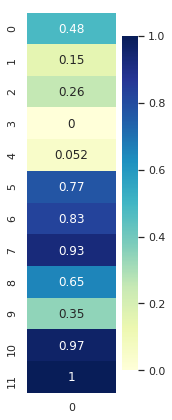

In [37]:
sns.set(rc={'figure.figsize':(2.0,7.0)})
sns.heatmap(df_h_s_attended_vector, annot=True, cmap='YlGnBu', )

# Between Sentences

In [38]:
model_s1 = Model(model.inputs,model.get_layer(name='sa1').output)
model_s2 = Model(model.inputs,model.get_layer(name='sa2').output)
model_s3 = Model(model.inputs,model.get_layer(name='sa3').output)
model_s4 = Model(model.inputs,model.get_layer(name='sa4').output)
model_s1.summary()
model_s2.summary()
model_s3.summary()
model_s4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sentence_vectors (InputLayer (None, 125, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 125, 16)           14416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 125, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 125, 32)           1568      
_________________________________________________________________
dropout_2 (Dropout)          (None, 125, 32)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 32)           128       
_________________________________________________________________
sa1 (SelfAttention)          [(None, 125, 32), (125, 1 2377      
Total para

In [39]:
_, sb1, sg1 = model_s1.predict([x['sentence_vectors'],x['input_headline_vector']])
_, sb2, sg2 = model_s2.predict(x)
_, sb3, sg3 = model_s3.predict(x)
_, sb4, sg4 = model_s4.predict(x)

In [40]:
sb = sb1[test_idx]#+sb2[test_idx]+sb3[test_idx]+sb4[test_idx]
sb = sb[:len(x['sentences'][test_idx]),:len(x['sentences'][test_idx])]

sb.shape

(12, 12)

In [41]:
df_sb = pd.DataFrame(sb)


# zx = df_sb.values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# zx_scaled = min_max_scaler.fit_transform(zx)
# df_sb = pd.DataFrame(zx_scaled)

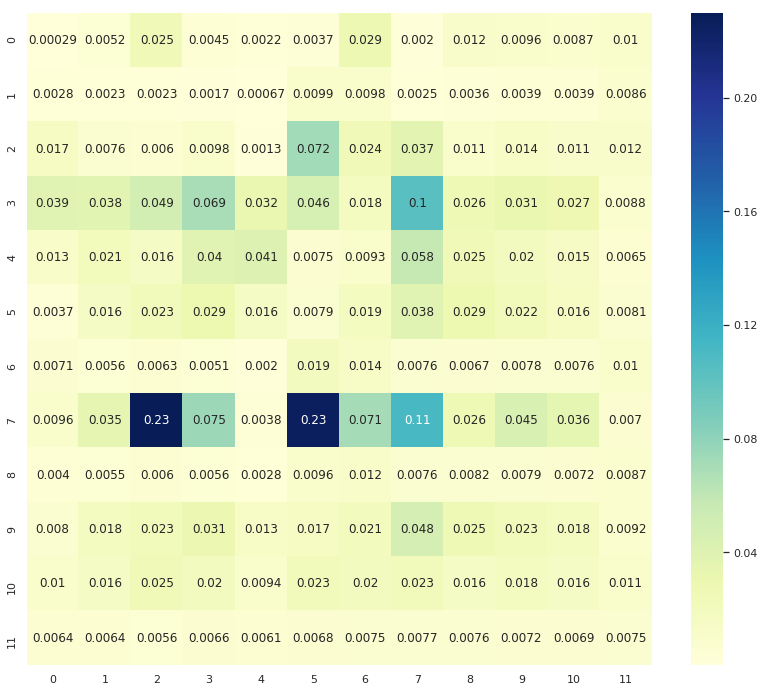

In [42]:
sns.set(rc={'figure.figsize':(14.0,12.0)})
sns.heatmap(pd.DataFrame(df_sb),annot=True,cmap='YlGnBu')

In [43]:
pd.DataFrame(x['sentences'][test_idx])

,0
0,"Before running against billionaire real estate mogul Donald Trump for the presidency, Secretary of State Hillary Clinton told an audience at a private, paid speech she wanted to see more successful businessmen and women run for office because they can’t be bought."
1,"In a speech made public by Wikileaks – which released an email from Hillary for America Research Director Tony Caark containing three attached speeches given at a private Goldman Sachs events – Clinton spoke and took audience questions at the “Builders and Innovators Summit” hosted by Goldman Sachs on October 29, 2013."
2,"Answering a question about businessmen in politics, Clinton said that they are “most often the people that look over the horizon,” and therefore share a vision that many politicians of today lack. “"
3,And that’s a very good question and thank you for asking it.
4,"Yes, I would love to see more businessmen go into politics because I believe they would bring in an entirely different mindset and strategies than what we’re used to seeing traditionally,” she opined."
5,And then she just had to go on. “
6,"In fact, when you say businessmen and women, I can’t help but think of a particular one that I would just love to see running for the presidency at some point in the future,” Clinton added. “"
7,"I don’t know what it is exactly about him, I can’t quite put my finger on it, but my instinct is almost never wrong."
8,And it’s telling me that Donald Trump would be very successful if he were to venture into politics in the future.”
9,"Asked to elaborate on her statement, the former Secretary of State argued that she thinks that businessmen “can’t be bought” and that they’re “very honest.” “"
